In [1]:
def one_hot_encode(y):
    values = np.unique(y).size
    encoded_outputs = []

    for i in range(len(y)):
        new_output = [0] * values
        new_output[y[i]] = 1
        encoded_outputs.append(new_output)

    return np.array(encoded_outputs)

In [2]:
import numpy as np
import math
import tensorflow

(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

x_train = x_train.reshape((60000, 784))
x_test = x_test.reshape((10000, 784))

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = x_train.T
x_test = x_test.T # Transposed to match the standard dimensions... The training/testing examples should be column vectors.

y_train_original = y_train
y_test_original = y_test

y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

y_train = y_train.T
y_test = y_test.T

2025-10-10 21:09:30.752114: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-10 21:09:30.752466: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-10 21:09:30.803410: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-10 21:09:31.858332: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [3]:
x_train.shape # Here, we will be implementing mini batch GD. We need to slice the x train array to get the first n columns where n is the batch size.

(784, 60000)

In [4]:
# slicing to get the first 10 training examples in x_train:
x_train[:, :10].shape

(784, 10)

In [5]:
# We shall be using something like this for the forward and backward prop now instead of the single column vectors being used in SGD. Everything else stays the same for now.

In [42]:
class DFN:
    def __init__(self):
        
        self.weights = []
        self.weights.append(0)
        self.weights.append(np.random.randn(128, 784) * np.sqrt(2. / 784)) 
        self.weights.append(np.random.randn(16, 128) * np.sqrt(2. / 128)) 
        self.weights.append(np.random.randn(10, 16) * np.sqrt(2. / 16))

        # initializing velocoties for the momentum optimizer.
        self.v_weights = []
        self.v_weights.append(0)
        self.v_weights.append(np.zeros((128, 784))) 
        self.v_weights.append(np.zeros((16, 128))) 
        self.v_weights.append(np.zeros((10, 16)))


        self.biases = []
        self.biases.append(0)
        self.biases.append(np.zeros((128, 1)))
        self.biases.append(np.zeros((16, 1)))
        self.biases.append(np.zeros((10, 1)))
        
        self.v_biases = []
        self.v_biases.append(0)
        self.v_biases.append(np.zeros((128, 1)))
        self.v_biases.append(np.zeros((16, 1)))
        self.v_biases.append(np.zeros((10, 1)))
        
        # Here, I have removed the sigmoid and it's derivative methods altogether. 

    def RELU(self, x):
        return np.maximum(x, 0)

    def RELU_derivative(self, x):
        return (x > 0).astype(int)

    def softmax(self, x):
        shifted_x = x - np.max(x, axis=0, keepdims=True)
        exps = np.exp(shifted_x)
        return exps / np.sum(exps, axis=0, keepdims=True)

    def softmax_derivative(self):
        pass # implemented in the code.

    def forward_prop(self, input): # This method can actually process mini batches as it already uses matrix multiplication.
        a = []
        z = []
        
        a.append(input)
        z.append([0])
        z_temp = (self.weights[1] @ a[0]) + self.biases[1]
        a_temp = self.RELU(z_temp)

        z.append(z_temp)
        a.append(a_temp)

        z_temp = (self.weights[2] @ a[1]) + self.biases[2]
        a_temp = self.RELU(z_temp)

        z.append(z_temp)
        a.append(a_temp)

        z_temp = (self.weights[3] @ a[2]) + self.biases[3]
        a_temp = self.softmax(z_temp)

        z.append(z_temp)
        a.append(a_temp)

        return z, a

    def back_prop(self, z, a, y, alpha):
        
        m = a[0].shape[1]
        
        dZ3 = a[3] - y 
        dW3 = (1 / m) * (dZ3 @ a[2].T)
        dB3 = (1 / m) * np.sum(dZ3, axis = 1, keepdims = True)
        
        dA2 = self.weights[3].T @ dZ3
        dZ2 = dA2 * self.RELU_derivative(z[2])
        dW2 = (1 / m) * (dZ2 @ a[1].T)
        dB2 = (1 / m) * np.sum(dZ2, axis = 1, keepdims = True)

        dA1 = self.weights[2].T @ dZ2 
        dZ1 = dA1 * self.RELU_derivative(z[1])
        dW1 = (1 / m) * (dZ1 @ a[0].T)
        dB1 = (1 / m) * np.sum(dZ1, axis = 1, keepdims = True)

        return {"dW1": dW1, "dB1": dB1, "dW2": dW2, "dB2": dB2, "dW3": dW3, "dB3": dB3}

    def SGD(self, gradients, alpha): # Pure gradient descent
  
        self.weights[3] -= alpha * gradients["dW3"]
        self.biases[3] -= alpha * gradients["dB3"]
        self.weights[2] -= alpha * gradients["dW2"]
        self.biases[2] -= alpha * gradients["dB2"]
        self.weights[1] -= alpha * gradients["dW1"]
        self.biases[1] -= alpha * gradients["dB1"]
            

    def SGD_with_momentum(self, gradients, alpha, beta): # Gradient descent with momentum

        # updating the momentum first. beta decides how much importance we should give to the momentum "remembered" from the previous iterations over the current gradients.
        self.v_weights[3] = beta * self.v_weights[3] + (1 - beta) * gradients["dW3"]
        self.v_biases[3] = beta * self.v_biases[3] + (1 - beta) * gradients["dB3"]
        self.v_weights[2] = beta * self.v_weights[2] + (1 - beta) * gradients["dW2"]
        self.v_biases[2] = beta * self.v_biases[2] + (1 - beta) * gradients["dB2"]
        self.v_weights[1] = beta * self.v_weights[1] + (1 - beta) * gradients["dW1"]
        self.v_biases[1] = beta * self.v_biases[1] + (1 - beta) * gradients["dB1"]

        # Now, we update using the momentum instead of the gradient. 
        self.weights[3] -= alpha * self.v_weights[3]
        self.biases[3] -= alpha * self.v_biases[3]
        self.weights[2] -= alpha * self.v_weights[2]
        self.biases[2] -= alpha * self.v_biases[2]
        self.weights[1] -= alpha * self.v_weights[1]
        self.biases[1] -= alpha * self.v_biases[1]
        
    def ADAM():
        pass

    def train_using_SGD(self, x_train, y_train, y_train_original, learning_rate = 0.2, epochs = 20, batch_size = 64):
        samples = x_train.shape[1]
        loss_history = []

        for epoch in range(epochs):
            print(f"Epoch - {epoch}")

            # Here, we shuffle the indices at every epoch.
            shuffled_index = np.random.permutation(samples)
            x_train_shuffled = x_train[:, shuffled_index]
            y_train_shuffled = y_train[:, shuffled_index]
            
            epoch_loss = 0
            
            for i in range(0, samples, batch_size):
                # Add a variable to hold the index of the end of the current batch, and use it in the indexing 
                # to extract a mini batch of columns instead of a single column.
                end = i + batch_size
                x_batch = x_train_shuffled[:, i:end]
                y_batch = y_train_shuffled[:, i:end]
    
                z, a = self.forward_prop(x_batch)

                gradients = self.back_prop(z, a, y_batch, alpha = learning_rate)
                
                self.SGD(gradients, learning_rate)
                
                y_class_indices = np.argmax(y_batch, axis = 0)
                epsilon = 1e-9 # or else log(0) gives inf.
                log_probs = - np.log(a[3][y_class_indices, np.arange(y_batch.shape[1])] + epsilon)
                loss = np.sum(log_probs)
                self.back_prop(z, a, y_batch, alpha = learning_rate)
                epoch_loss += loss
                
            # calculate epoch loss averaged over epoch
            epoch_loss /= samples
            loss_history.append(epoch_loss)
            print(f"Epoch loss = {epoch_loss}\n")

        print("Training complete.")

        return loss_history

        
    # New train method that uses SGD with momentum.
    def train_using_momentum(self, x_train, y_train, y_train_original, learning_rate = 0.2, momentum_influence = 0.9, epochs = 20, batch_size = 64):
        samples = x_train.shape[1]
        loss_history = []

        for epoch in range(epochs):
            print(f"Epoch - {epoch}")

            # Here, we shuffle the indices at every epoch.
            shuffled_index = np.random.permutation(samples)
            x_train_shuffled = x_train[:, shuffled_index]
            y_train_shuffled = y_train[:, shuffled_index]
            
            epoch_loss = 0
            
            for i in range(0, samples, batch_size):
                # Add a variable to hold the index of the end of the current batch, and use it in the indexing 
                # to extract a mini batch of columns instead of a single column.
                end = i + batch_size
                x_batch = x_train_shuffled[:, i:end]
                y_batch = y_train_shuffled[:, i:end]
    
                z, a = self.forward_prop(x_batch)

                gradients = self.back_prop(z, a, y_batch, alpha = learning_rate)
                
                self.SGD_with_momentum(gradients, learning_rate, momentum_influence)
                
                y_class_indices = np.argmax(y_batch, axis = 0)
                epsilon = 1e-9 # or else log(0) gives inf.
                log_probs = - np.log(a[3][y_class_indices, np.arange(y_batch.shape[1])] + epsilon)
                loss = np.sum(log_probs)
                self.back_prop(z, a, y_batch, alpha = learning_rate)
                epoch_loss += loss
                
            # calculate epoch loss averaged over epoch
            epoch_loss /= samples
            loss_history.append(epoch_loss)
            print(f"Epoch loss = {epoch_loss}\n")

        print("Training complete.")

        return loss_history

In [37]:
# Model testing

def evaluate_model(model, x_test, y_test_original):
    print("\nStarting model evaluation on the test set...")
    
    correct_predictions = 0
    num_samples = x_test.shape[1]

    for i in range(num_samples):
        image = x_test[:, i].reshape(-1, 1)
        true_label = y_test_original[i]

        _, a = model.forward_prop(image)
        predicted_label = np.argmax(a[3])

        if predicted_label == true_label:
            correct_predictions += 1
            
    accuracy = (correct_predictions / num_samples) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    print(f"Correctly classified {correct_predictions} out of {num_samples} samples.")

Training model with standard SGD...
Epoch - 0
Epoch loss = 0.31457679187105947

Epoch - 1
Epoch loss = 0.1198489014284811

Epoch - 2
Epoch loss = 0.08430405039680622

Epoch - 3
Epoch loss = 0.06614323233609752

Epoch - 4
Epoch loss = 0.053755027360358455

Epoch - 5
Epoch loss = 0.04307946890461236

Epoch - 6
Epoch loss = 0.035564723903761836

Epoch - 7
Epoch loss = 0.02896763876820643

Epoch - 8
Epoch loss = 0.021830143275682626

Epoch - 9
Epoch loss = 0.018350563447344165

Epoch - 10
Epoch loss = 0.014467651000241733

Epoch - 11
Epoch loss = 0.010590924573860778

Epoch - 12
Epoch loss = 0.007009414352192431

Epoch - 13
Epoch loss = 0.005047270303959652

Epoch - 14
Epoch loss = 0.0028649806161674864

Epoch - 15
Epoch loss = 0.0019039676593107814

Epoch - 16
Epoch loss = 0.0013018286020965075

Epoch - 17
Epoch loss = 0.0009537023046865028

Epoch - 18
Epoch loss = 0.0007930634783405213

Epoch - 19
Epoch loss = 0.0006757327244817084

Training complete.

Starting model evaluation on the te

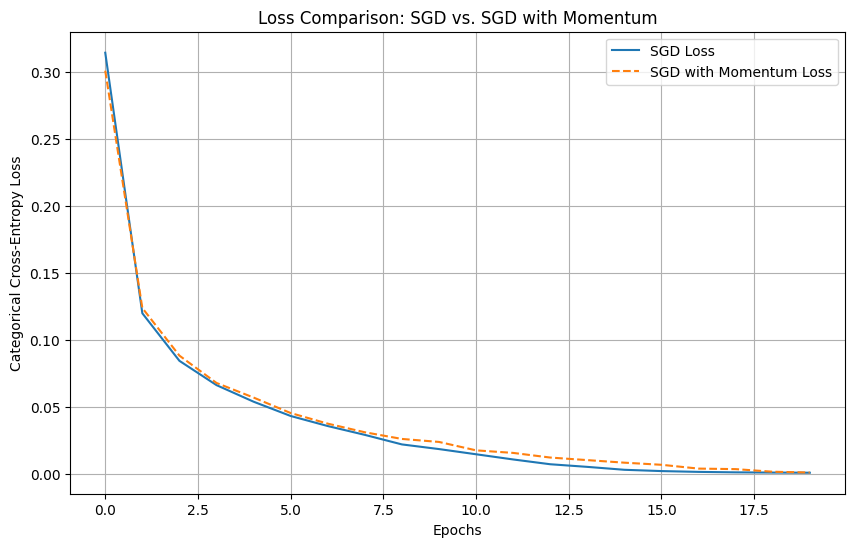

In [43]:
import matplotlib.pyplot as plt

# We are doing this to observe the difference between the plain SGD and the SGD with momentum optimizers.
# We do this using a matplotlib graph.
print("Training model with standard SGD...")
model_sgd = DFN()

sgd_loss_history = model_sgd.train_using_SGD(x_train, y_train, y_train_original, epochs=20)
evaluate_model(model_sgd, x_test, y_test_original)

print("\\nTraining model with Momentum...")
model_momentum = DFN()
momentum_loss_history = model_momentum.train_using_momentum(x_train, y_train, y_train_original, epochs=20)
evaluate_model(model_momentum, x_test, y_test_original)


plt.figure(figsize=(10, 6))
plt.plot(sgd_loss_history, label='SGD Loss')
plt.plot(momentum_loss_history, label='SGD with Momentum Loss', linestyle='--')

plt.title('Loss Comparison: SGD vs. SGD with Momentum')
plt.xlabel('Epochs')
plt.ylabel('Categorical Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()